<h1>Chapter 02. End-to-end Machine Learning Project</h1>

Creating a predictive housing price model for California using detailed census data, including metrics like population, median income, and more, for each block group in the state. This model is designed to forecast median home values in any county based on these metrics.

<h2>Get the Data</h2>

<h3>Download the Data</h3>

In [1]:
import os
import tarfile

from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join('datasets', 'housing')
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"


# Define a function to download, open the file and create a folder to store the data
def fetch_housing_data(url=HOUSING_URL, path=HOUSING_PATH):
    if not os.path.isdir(path):
        os.makedirs(path)
    tgz_path = os.path.join(path, 'housing.tgz')
    urllib.request.urlretrieve(url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=path)
    housing_tgz.close()

In [2]:
fetch_housing_data()

<h3>Take a Quick Look at the Data Structure</h3>

In [3]:
import pandas as pd


def load_housing_data(path=HOUSING_PATH):
    csv_path = os.path.join(path, 'housing.csv')
    return pd.read_csv(csv_path)

In [4]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
housing.tail()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND
20639,-121.24,39.37,16.0,2785.0,616.0,1387.0,530.0,2.3886,89400.0,INLAND


<h3>Get DataFrame info</h3>

In [6]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [7]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


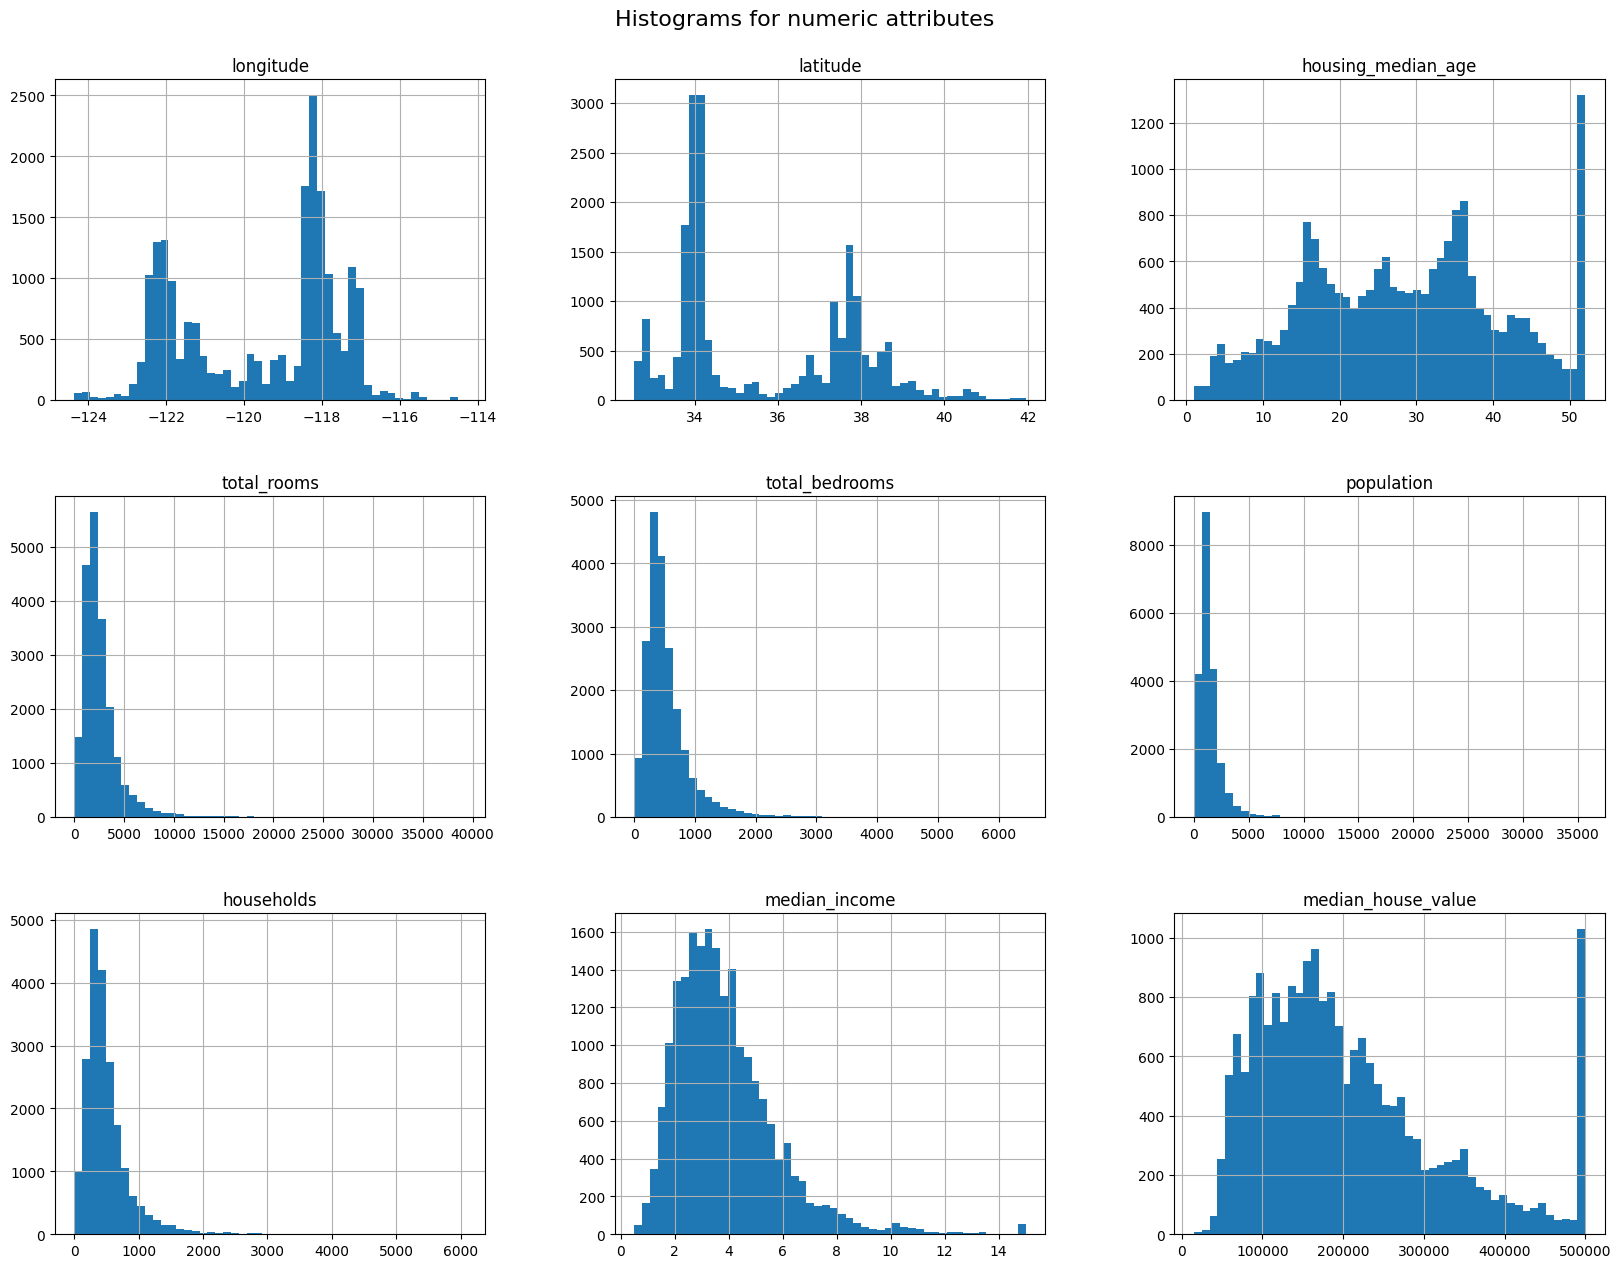

In [8]:
import matplotlib.pyplot as plt

# Plot histograms for numeric attributes
housing.hist(bins=50, figsize=(20, 15))
plt.figtext(
    0.5,
    0.92,
    'Histograms for numeric attributes',
    ha='center',
    va='center',
    fontsize=16,
)
plt.show()

<h3>Create a Test Set</h3>

In [9]:
import numpy as np

# To make this notebook's output identical at every run
np.random.seed(42)

In [10]:
def split_train_test(data, test_ratio):
    shaffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shaffled_indices[:test_set_size]
    train_indices = shaffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [11]:
train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set), "train +", len(test_set), "test")

16512 train + 4128 test


In [12]:
import hashlib


# Define a function to determine if a sample should be placed in the test set
def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

In [13]:
# Define a function to split a dataset into training and test sets based on sample IDs
def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [14]:
housing_with_id = housing.reset_index()  # adds an 'index' column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, 'index')

In [15]:
# Create stable identifier by combining latitude and longitude
housing_with_id['id'] = housing['longitude'] * 1000 + housing['latitude']
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, 'id')

In [16]:
train_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
0,0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,-122192.12
1,1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,-122182.14
2,2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,-122202.15
3,3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,-122212.15
4,4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,-122212.15


In [17]:
test_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
8,8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY,-122222.16
10,10,-122.26,37.85,52.0,2202.0,434.0,910.0,402.0,3.2031,281500.0,NEAR BAY,-122222.15
11,11,-122.26,37.85,52.0,3503.0,752.0,1504.0,734.0,3.2705,241800.0,NEAR BAY,-122222.15
12,12,-122.26,37.85,52.0,2491.0,474.0,1098.0,468.0,3.0750,213500.0,NEAR BAY,-122222.15
13,13,-122.26,37.84,52.0,696.0,191.0,345.0,174.0,2.6736,191300.0,NEAR BAY,-122222.16


In [18]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and test sets using Scikit-Learn's
# train_test_split function
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [19]:
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


<Axes: >

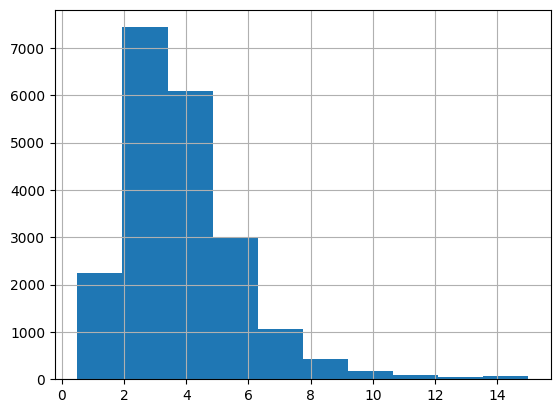

In [20]:
housing['median_income'].hist()

In [21]:
# Create income categories for strata balance
housing['income_cat'] = np.ceil(housing['median_income'] / 1.5)
housing['income_cat'].where(housing['income_cat'] < 5, 5.0, inplace=True)

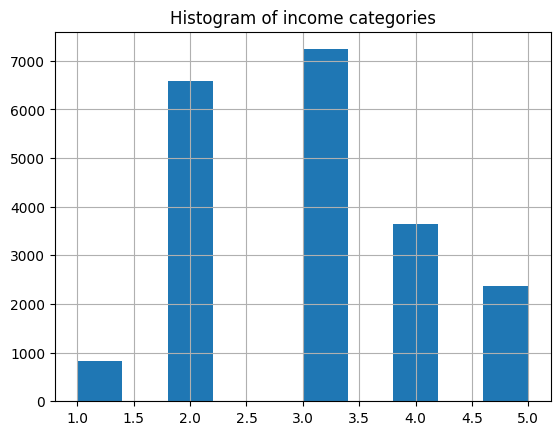

In [22]:
housing['income_cat'].hist()
plt.title('Histogram of income categories')
plt.show()

In [23]:
from sklearn.model_selection import StratifiedShuffleSplit

# Stratified sample by income category with Scikit-Learn's StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [24]:
housing['income_cat'].value_counts() / len(housing)

income_cat
3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: count, dtype: float64

In [25]:
# Compare the sampling biases of stratified and random sampling
def income_cat_proportions(data):
    return data['income_cat'].value_counts() / len(data)


train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame(
    {
        'Overall': income_cat_proportions(housing),
        'Stratified': income_cat_proportions(strat_test_set),
        'Random': income_cat_proportions(test_set),
    }
).sort_index()

compare_props['Rand. %error'] = (
    100 * compare_props['Random'] / compare_props['Overall'] - 100
)
compare_props['Strat. %error'] = (
    100 * compare_props['Stratified'] / compare_props['Overall'] - 100
)

compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
income_cat,,,,,
1.0,0.039826,0.039971,0.040213,0.973236,0.364964
2.0,0.318847,0.318798,0.324370,1.732260,-0.015195
3.0,0.350581,0.350533,0.358527,2.266446,-0.013820
4.0,0.176308,0.176357,0.167393,-5.056334,0.027480
5.0,0.114438,0.114341,0.109496,-4.318374,-0.084674


In [26]:
# Remove atribute 'income_cat' to revert the data back to its original state
for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_cat', axis=1, inplace=True)

<h2>Discover and Visualize the Data to Gain Insights</h2>

In [27]:
housing = strat_train_set.copy()

<h3>Visualising Geographical Data</h3>

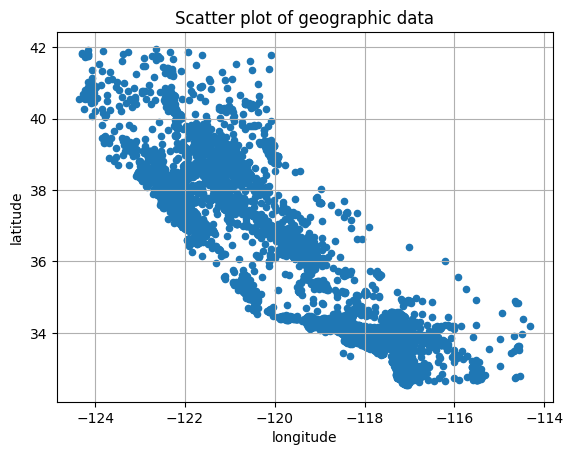

In [28]:
housing.plot(
    kind='scatter',
    x='longitude',
    y='latitude',
)
plt.title('Scatter plot of geographic data')
plt.grid(True)
plt.show()

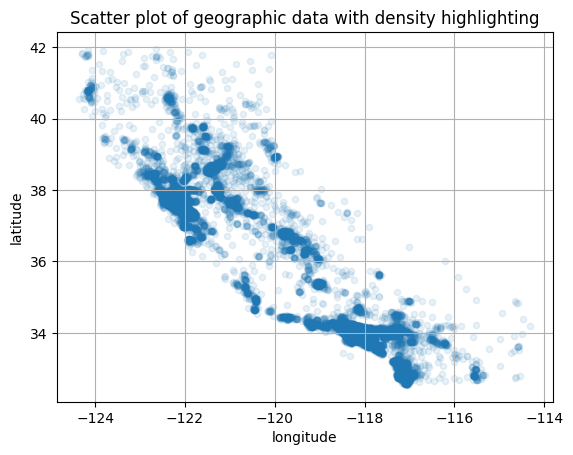

In [29]:
# Add an aplha parametr to define high density
housing.plot(
    kind='scatter',
    x='longitude',
    y='latitude',
    alpha=0.1,
)
plt.title('Scatter plot of geographic data with density highlighting')
plt.grid(True)
plt.show()

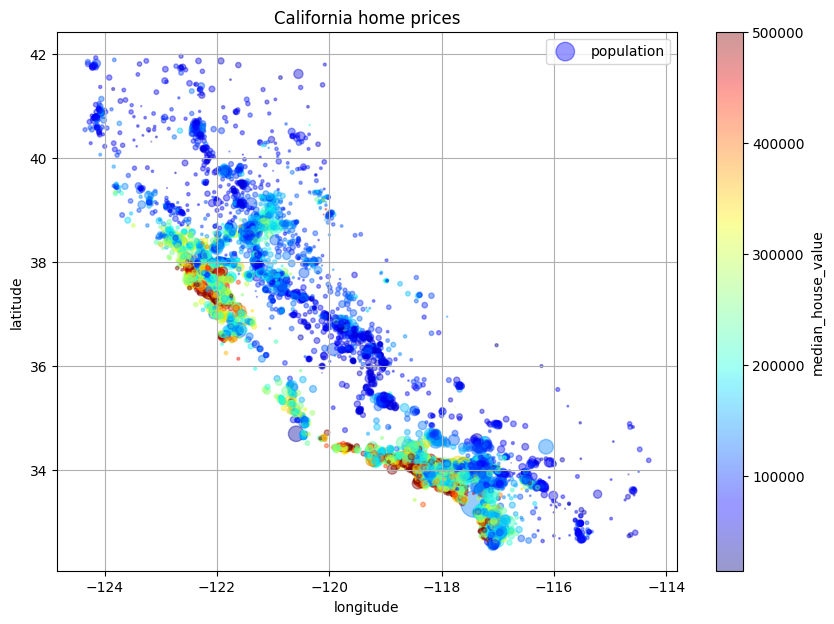

In [30]:
# Add visualisation parameters
housing.plot(
    kind='scatter',
    x='longitude',
    y='latitude',
    alpha=0.4,
    s=housing['population'] / 100,  # population radius of the county
    label='population',
    figsize=(10, 7),
    c='median_house_value',  # price in the county
    cmap=plt.get_cmap('jet'),
    colorbar=True,
)
plt.title('California home prices')
plt.grid(True)
plt.show()

<h3>Looking for Correlations</h3>

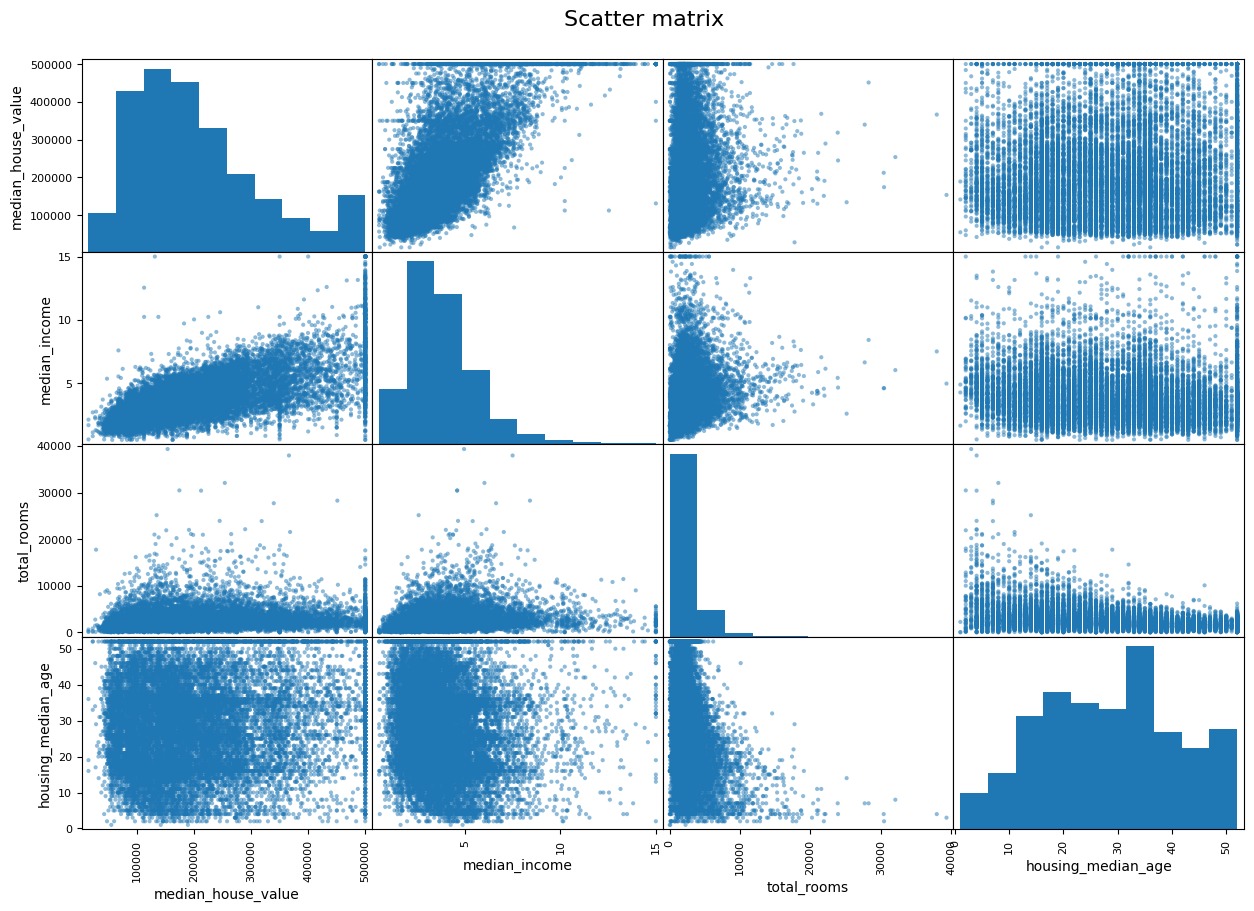

In [31]:
from pandas.plotting import scatter_matrix

attributes = [
    'median_house_value',
    'median_income',
    'total_rooms',
    'housing_median_age',
]
scatter_matrix(housing[attributes], figsize=(15, 10))
plt.figtext(
    0.5,
    0.92,
    'Scatter matrix',
    ha='center',
    va='center',
    fontsize=16,
)
plt.show()

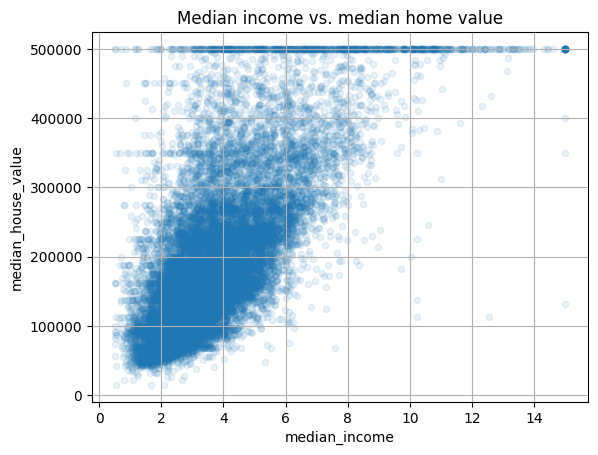

In [32]:
housing.plot(
    kind='scatter',
    x='median_income',
    y='median_house_value',
    alpha=0.1,
)
plt.title('Median income vs. median home value')
plt.grid(True)
plt.show()

<h3>Experimenting with Attribute Combinations</h3>

In [33]:
housing['rooms_per_household'] = housing['total_rooms'] / housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms'] / housing['total_rooms']
housing['population_per_household'] = housing['population'] / housing['households']

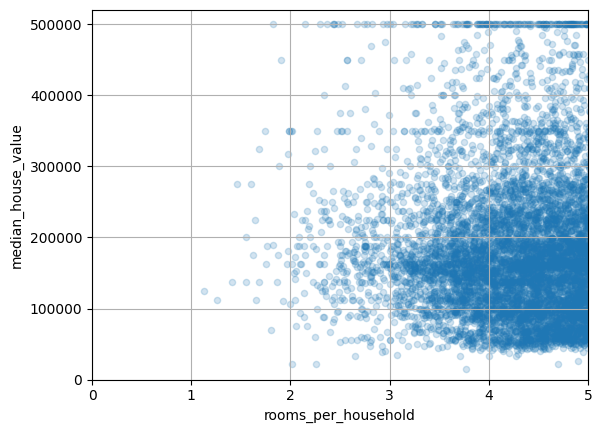

In [34]:
housing.plot(
    kind='scatter',
    x='rooms_per_household',
    y='median_house_value',
    alpha=0.2,
)
plt.axis([0, 5, 0, 520000])
plt.grid(True)
plt.show()

In [35]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household
count,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000
mean,-119.575635,35.639314,28.653404,2622.539789,534.914639,1419.687379,497.011810,3.875884,207005.322372,5.440406,0.212873,3.096469
std,2.001828,2.137963,12.574819,2138.417080,412.665649,1115.663036,375.696156,1.904931,115701.297250,2.611696,0.057378,11.584825
min,-124.350000,32.540000,1.000000,6.000000,2.000000,3.000000,2.000000,0.499900,14999.000000,1.130435,0.100000,0.692308
25%,-121.800000,33.940000,18.000000,1443.000000,295.000000,784.000000,279.000000,2.566950,119800.000000,4.442168,0.175304,2.431352
50%,-118.510000,34.260000,29.000000,2119.000000,433.000000,1164.000000,408.000000,3.541550,179500.000000,5.232342,0.203027,2.817661
75%,-118.010000,37.720000,37.000000,3141.000000,644.000000,1719.000000,602.000000,4.745325,263900.000000,6.056361,0.239816,3.281420
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100,500001.000000,141.909091,1.000000,1243.333333


<h2>Prepare the Data for Machine Learning Algorithms</h2>

In [36]:
# Drop labels for training set
housing = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

<h3>Data cleaning</h3>

In [37]:
# Fill in missing values with medians
median = housing['total_bedrooms'].median()
housing['total_bedrooms'].fillna(median, inplace=True)

In [38]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,INLAND
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,NEAR OCEAN
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,INLAND
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,NEAR OCEAN
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,<1H OCEAN


The Scikit-Learn module has a SimpleImputer module to fill in missing values

In [39]:
from sklearn.impute import SimpleImputer

# Create a SimpleImputer instance and set the median function
imputer = SimpleImputer(strategy='median')

# Remove column ocean_proximity with text type data
housing_num = housing.drop('ocean_proximity', axis=1)
imputer.fit(housing_num)

housing_num

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964
...,...,...,...,...,...,...,...,...
15174,-117.07,33.03,14.0,6665.0,1231.0,2026.0,1001.0,5.0900
12661,-121.42,38.51,15.0,7901.0,1422.0,4769.0,1418.0,2.8139
19263,-122.72,38.44,48.0,707.0,166.0,458.0,172.0,3.1797
19140,-122.70,38.31,14.0,3155.0,580.0,1208.0,501.0,4.1964


In [40]:
imputer.statistics_

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

Check that this is the same as manually computing the median of each attribute

In [41]:
housing_num.median().values

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

Transform the training set

In [42]:
X = imputer.transform(housing_num)

In [43]:
housing_tr = pd.DataFrame(
    X,
    columns=housing_num.columns,
    index=housing_num.index,
)

housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964


<h3>Handling Text and Categorical Attributes</h3>

Preprocess the categorical imput feature ocean_proximity

In [44]:
housing_cat = housing['ocean_proximity']
housing_cat.head(10)

12655        INLAND
15502    NEAR OCEAN
2908         INLAND
14053    NEAR OCEAN
20496     <1H OCEAN
1481       NEAR BAY
18125     <1H OCEAN
5830      <1H OCEAN
17989     <1H OCEAN
4861      <1H OCEAN
Name: ocean_proximity, dtype: object

In [45]:
# Convert text to numbers using Pandas factorize() method
housing_cat_encoded, housing_categories = housing_cat.factorize()

In [46]:
housing_cat_encoded[:10]

array([0, 1, 0, 1, 2, 3, 2, 2, 2, 2])

In [47]:
housing_categories

Index(['INLAND', 'NEAR OCEAN', '<1H OCEAN', 'NEAR BAY', 'ISLAND'], dtype='object')

In [48]:
from sklearn.preprocessing import OneHotEncoder

# Add sparse_output=False to dense array
cat_encoder = OneHotEncoder(sparse_output=False)

# Reshape your data either using array.reshape(-1, 1)
housing_cat_reshaped = housing_cat.values.reshape(-1, 1)
housing_cat_onehot = cat_encoder.fit_transform(housing_cat_reshaped)

housing_cat_onehot

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [49]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

<h3>Custom Transformers</h3>

Create a custom transfomer to add extra attributes

In [50]:
from sklearn.base import BaseEstimator, TransformerMixin

# Get the column indices
column_names = 'total_rooms', 'total_bedrooms', 'population', 'households'
rooms_ix, bedrooms_ix, population_ix, household_ix = [
    housing.columns.get_loc(col) for col in column_names
]


class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):  # no *args or **kwargs
        self.add_bedrooms_per_room = add_bedrooms_per_room

    def fit(self, X, y=None):
        return self  # nothing else to do

    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[
                X,
                rooms_per_household,
                population_per_household,
                bedrooms_per_room,
            ]
        else:
            return np.c_[
                X,
                rooms_per_household,
                population_per_household,
            ]


attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

housing_extra_attribs

array([[-121.46, 38.52, 29.0, ..., 'INLAND', 5.485835694050992,
        3.168555240793201],
       [-117.23, 33.09, 7.0, ..., 'NEAR OCEAN', 6.927083333333333,
        2.6236979166666665],
       [-119.04, 35.37, 44.0, ..., 'INLAND', 5.3933333333333335,
        2.223333333333333],
       ...,
       [-122.72, 38.44, 48.0, ..., '<1H OCEAN', 4.1104651162790695,
        2.6627906976744184],
       [-122.7, 38.31, 14.0, ..., '<1H OCEAN', 6.297405189620759,
        2.411177644710579],
       [-122.14, 39.97, 27.0, ..., 'INLAND', 5.477157360406092,
        3.1725888324873095]], dtype=object)

housing_extra_attribs is a NumPy array, we've lost column names

In [51]:
# Recover a DataFrame
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns) + ['rooms_per_household', 'population_per_household'],
    index=housing.index,
)

housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,INLAND,5.485836,3.168555
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,NEAR OCEAN,6.927083,2.623698
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.875,INLAND,5.393333,2.223333
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,NEAR OCEAN,3.886128,1.859213
20496,-118.7,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,<1H OCEAN,6.096552,3.167241


<h3>Transformation Pipelines</h3>

Build a pipeline for preprocessing a numerical attributes

In [52]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline(
    [
        ('imputer', SimpleImputer(strategy='median')),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ]
)
housing_num_tr = num_pipeline.fit_transform(housing_num)

housing_num_tr

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.01739526,
         0.00622264, -0.12112176],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.56925554,
        -0.04081077, -0.81086696],
       [ 0.26758118, -0.1259716 ,  1.22045984, ..., -0.01802432,
        -0.07537122, -0.33827252],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ..., -0.5092404 ,
        -0.03743619,  0.32286937],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.32814891,
        -0.05915604, -0.45702273],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.01407228,
         0.00657083, -0.12169672]])

DataFrameSelector transformer (to just select a subset of the Pandas DataFrame columns)

In [53]:
from sklearn.base import BaseEstimator, TransformerMixin


# Create a class to select numerical or categorical columns
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.attribute_names].values

Join all these components into a big pipeline that will preprocess both the numerical and the categorical features

In [54]:
num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

num_pipeline = Pipeline(
    [
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', SimpleImputer(strategy='median')),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ]
)

cat_pipeline = Pipeline(
    [
        ('selector', DataFrameSelector(cat_attribs)),
        ('cat_encoder', OneHotEncoder(sparse_output=False)),
    ]
)

In [55]:
from sklearn.pipeline import FeatureUnion

# Combine pipelines using FeatureUnion
full_pipeline = FeatureUnion(
    transformer_list=[('num_pipeline', num_pipeline), ('cat_pipeline', cat_pipeline)]
)
housing_prepared = full_pipeline.fit_transform(housing)

housing_prepared

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.26758118, -0.1259716 ,  1.22045984, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ...,  0.        ,
         0.        ,  0.        ],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.        ,
         0.        ,  0.        ]])

In [56]:
housing_prepared.shape

(16512, 16)

<h2>Select and Train a Model</h2>

<h3>Training and Evaluating on the Training Set</h3>

In [57]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

Try the full preprocessing pipeline on a few training instances

In [58]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [ 85657.90192014 305492.60737488 152056.46122456 186095.70946094
 244550.67966089]


Compare against the actual values

In [59]:
print("Labels:", list(some_labels))

Labels: [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


In [60]:
some_data_prepared

array([[-0.94135046,  1.34743822,  0.02756357,  0.58477745,  0.64037127,
         0.73260236,  0.55628602, -0.8936472 ,  0.01739526,  0.00622264,
        -0.12112176,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ],
       [ 1.17178212, -1.19243966, -1.72201763,  1.26146668,  0.78156132,
         0.53361152,  0.72131799,  1.292168  ,  0.56925554, -0.04081077,
        -0.81086696,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ],
       [ 0.26758118, -0.1259716 ,  1.22045984, -0.46977281, -0.54513828,
        -0.67467519, -0.52440722, -0.52543365, -0.01802432, -0.07537122,
        -0.33827252,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ],
       [ 1.22173797, -1.35147437, -0.37006852, -0.34865152, -0.03636724,
        -0.46761716, -0.03729672, -0.86592882, -0.59513997, -0.10680295,
         0.96120521,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ],
       [ 0.43743108, -0.63581817, -0

Measure the RMSE error of this regression model on the training set

In [61]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)

lin_rmse

68627.87390018745

DecisionTreeRegressor: A regression model using decision tree structure for numeric predictions.

In [62]:
from sklearn.tree import DecisionTreeRegressor

# Create a DecisionTreeRegressor with a fixed random state for reproducible results
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(random_state=42)

In [63]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)

tree_rmse

0.0

<h3>Better Evaluation using Cross-Validation</h3>

Evaluate a model's performance using cross_val_score.

In [64]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(
    tree_reg,  # model to evaluate
    housing_prepared,
    housing_labels,
    scoring='neg_mean_squared_error',  # scoring metric (negative mean squared error)
    cv=10,  # number of cross-validation folds
)
tree_rmse_scores = np.sqrt(-scores)

In [65]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [66]:
display_scores(tree_rmse_scores)

Scores: [72831.45749112 69973.18438322 69528.56551415 72517.78229792
 69145.50006909 79094.74123727 68960.045444   73344.50225684
 69826.02473916 71077.09753998]
Mean: 71629.89009727491
Standard deviation: 2914.035468468928


Calculate the same amounts for linear regression models

In [67]:
lin_scores = cross_val_score(
    lin_reg,
    housing_prepared,
    housing_labels,
    scoring='neg_mean_squared_error',
    cv=10,
)
lin_rmse_scores = np.sqrt(-lin_scores)

In [68]:
display_scores(lin_rmse_scores)

Scores: [71777.99302671 64114.99166359 67771.17124356 68627.60685191
 66847.73664349 72526.94613237 73984.4900656  68778.3587375
 66443.28836884 70153.97812964]
Mean: 69102.65608631991
Standard deviation: 2880.2457929897346


RandomForestRegressor: An ensemble regression model that combines multiple decision trees for improved predictive accuracy.

In [69]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(
    n_estimators=100,  # future-proof since the default value is going to change to 100
    random_state=42,
)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(random_state=42)

In [70]:
forest_scores = cross_val_score(
    forest_reg,
    housing_prepared,
    housing_labels,
    scoring='neg_mean_squared_error',
    cv=10,
)
forest_rmse_scores = np.sqrt(-forest_scores)

In [71]:
display_scores(forest_rmse_scores)

Scores: [51559.63379638 48737.57100062 47210.51269766 51875.21247297
 47577.50470123 51863.27467888 52746.34645573 50065.1762751
 48664.66818196 54055.90894609]
Mean: 50435.58092066179
Standard deviation: 2203.3381412764606


In [72]:
scores = cross_val_score(
    lin_reg,
    housing_prepared,
    housing_labels,
    scoring='neg_mean_squared_error',
    cv=10,
)
pd.Series(np.sqrt(-scores)).describe()

count       10.000000
mean     69102.656086
std       3036.045642
min      64114.991664
25%      67078.595294
50%      68702.982795
75%      71371.989302
max      73984.490066
dtype: float64

Create a Support Vector Regressor (SVR) with a linear kernel, fit it to the prepared data, make predictions, and calculate RMSE.

In [73]:
from sklearn.svm import SVR

svm_reg = SVR(kernel='linear')
svm_reg.fit(housing_prepared, housing_labels)

housing_predictions = svm_reg.predict(housing_prepared)

svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)

svm_rmse

111095.06635291968

<h2>Fine-Tune your Model</h2>

<h3>Grid Search</h3>

In [74]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {
        'n_estimators': [3, 10, 30],  # try 12 (3 × 4) combinations of hyperparameters
        'max_features': [2, 4, 6, 8],
    },
    {
        'bootstrap': [False],  # try 6 (2 × 3) combinations with bootstrap set as False
        'n_estimators': [3, 10],
        'max_features': [2, 3, 4],
    },
]

forest_reg = RandomForestRegressor()

# Train across 5 folds, that's a total of (12 + 6) * 5 = 90 rounds of training
grid_search = GridSearchCV(
    forest_reg,
    param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             scoring='neg_mean_squared_error')

In [75]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [76]:
grid_search.best_estimator_

RandomForestRegressor(max_features=6, n_estimators=30)

The score of each hyperparameter combination tested during the grid search

In [77]:
cvres = grid_search.cv_results_

for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

64807.49021188076 {'max_features': 2, 'n_estimators': 3}
55782.50962723946 {'max_features': 2, 'n_estimators': 10}
52998.79531819947 {'max_features': 2, 'n_estimators': 30}
60696.2725110334 {'max_features': 4, 'n_estimators': 3}
52992.503725629445 {'max_features': 4, 'n_estimators': 10}
50493.083768022625 {'max_features': 4, 'n_estimators': 30}
58973.764190053014 {'max_features': 6, 'n_estimators': 3}
52080.60819921695 {'max_features': 6, 'n_estimators': 10}
49911.03888082064 {'max_features': 6, 'n_estimators': 30}
59373.53316776424 {'max_features': 8, 'n_estimators': 3}
52593.83810503163 {'max_features': 8, 'n_estimators': 10}
50133.4257044498 {'max_features': 8, 'n_estimators': 30}
62060.75624619936 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54262.74855878277 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
58926.593201736 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52914.4923989621 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10}


In [78]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.080463,0.006209,0.003321,0.000171,2,3,NaN,"{'max_features': 2, 'n_estimators': 3}",-4.116568e+09,-3.901172e+09,-4.150100e+09,-4.222840e+09,-4.609374e+09,-4.200011e+09,2.310230e+08,18
1,0.264583,0.006774,0.009133,0.000755,2,10,NaN,"{'max_features': 2, 'n_estimators': 10}",-3.068735e+09,-2.952670e+09,-3.060057e+09,-3.255993e+09,-3.220986e+09,-3.111688e+09,1.118637e+08,11
2,0.776985,0.007627,0.025741,0.001538,2,30,NaN,"{'max_features': 2, 'n_estimators': 30}",-2.833685e+09,-2.701929e+09,-2.687861e+09,-2.900438e+09,-2.920448e+09,-2.808872e+09,9.749842e+07,9
3,0.127261,0.002823,0.003382,0.000382,4,3,NaN,"{'max_features': 4, 'n_estimators': 3}",-3.519311e+09,-3.528438e+09,-3.682452e+09,-3.627983e+09,-4.062004e+09,-3.684037e+09,1.986703e+08,16
4,0.423684,0.005549,0.009182,0.001007,4,10,NaN,"{'max_features': 4, 'n_estimators': 10}",-2.818169e+09,-2.780835e+09,-2.735285e+09,-2.790024e+09,-2.916714e+09,-2.808205e+09,6.044906e+07,8
5,1.274911,0.026260,0.024209,0.000390,4,30,NaN,"{'max_features': 4, 'n_estimators': 30}",-2.618847e+09,-2.485712e+09,-2.394155e+09,-2.570554e+09,-2.678489e+09,-2.549552e+09,1.000914e+08,3
6,0.174827,0.006361,0.003110,0.000058,6,3,NaN,"{'max_features': 6, 'n_estimators': 3}",-3.467397e+09,-3.411672e+09,-3.358732e+09,-3.560665e+09,-3.591058e+09,-3.477905e+09,8.758096e+07,14
7,0.589107,0.004612,0.009150,0.000626,6,10,NaN,"{'max_features': 6, 'n_estimators': 10}",-2.749507e+09,-2.640998e+09,-2.610856e+09,-2.789888e+09,-2.770699e+09,-2.712390e+09,7.237328e+07,5
8,1.784869,0.016548,0.024502,0.001184,6,30,NaN,"{'max_features': 6, 'n_estimators': 30}",-2.513479e+09,-2.426608e+09,-2.351016e+09,-2.544207e+09,-2.620250e+09,-2.491112e+09,9.357742e+07,1
9,0.232493,0.008907,0.003188,0.000078,8,3,NaN,"{'max_features': 8, 'n_estimators': 3}",-3.581217e+09,-3.515696e+09,-3.644874e+09,-3.394567e+09,-3.489728e+09,-3.525216e+09,8.470347e+07,15


<h3>Randomized Search</h3>

In [79]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    'n_estimators': randint(low=1, high=200),
    'max_features': randint(low=1, high=8),
}

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(
    forest_reg,
    param_distributions=param_distribs,
    scoring='neg_mean_squared_error',
    n_iter=10,
    random_state=42,
    cv=5,
)
rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x1249cb4a0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x124da5bb0>},
                   random_state=42, scoring='neg_mean_squared_error')

In [80]:
cvres = rnd_search.cv_results_

for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

49117.55344336652 {'max_features': 7, 'n_estimators': 180}
51450.63202856348 {'max_features': 5, 'n_estimators': 15}
50692.53588182537 {'max_features': 3, 'n_estimators': 72}
50783.614493515 {'max_features': 5, 'n_estimators': 21}
49162.89877456354 {'max_features': 7, 'n_estimators': 122}
50655.798471042704 {'max_features': 3, 'n_estimators': 75}
50513.856319990606 {'max_features': 3, 'n_estimators': 88}
49521.17201976928 {'max_features': 5, 'n_estimators': 100}
50302.90440763418 {'max_features': 3, 'n_estimators': 150}
65167.02018649492 {'max_features': 5, 'n_estimators': 2}


In [81]:
pd.DataFrame(rnd_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,12.473792,0.128225,0.147857,0.005139,7,180,"{'max_features': 7, 'n_estimators': 180}",-2.399428e+09,-2.335777e+09,-2.313461e+09,-2.476625e+09,-2.537379e+09,-2.412534e+09,8.434791e+07,1
1,0.775627,0.013085,0.014448,0.001041,5,15,"{'max_features': 5, 'n_estimators': 15}",-2.597812e+09,-2.590195e+09,-2.528533e+09,-2.769539e+09,-2.749759e+09,-2.647168e+09,9.513750e+07,9
2,2.466496,0.012564,0.057555,0.001674,3,72,"{'max_features': 3, 'n_estimators': 72}",-2.569955e+09,-2.512528e+09,-2.438188e+09,-2.656741e+09,-2.671254e+09,-2.569733e+09,8.769636e+07,7
3,1.118579,0.024016,0.017637,0.000475,5,21,"{'max_features': 5, 'n_estimators': 21}",-2.583962e+09,-2.515286e+09,-2.474528e+09,-2.649628e+09,-2.671474e+09,-2.578976e+09,7.554893e+07,8
4,8.558611,0.220246,0.099161,0.005070,7,122,"{'max_features': 7, 'n_estimators': 122}",-2.403611e+09,-2.347924e+09,-2.328235e+09,-2.466494e+09,-2.538690e+09,-2.416991e+09,7.757318e+07,2
5,2.537907,0.034031,0.061181,0.002405,3,75,"{'max_features': 3, 'n_estimators': 75}",-2.570132e+09,-2.508518e+09,-2.437703e+09,-2.653315e+09,-2.660383e+09,-2.566010e+09,8.522149e+07,6
6,3.213405,0.030028,0.079026,0.003844,3,88,"{'max_features': 3, 'n_estimators': 88}",-2.554075e+09,-2.501453e+09,-2.419114e+09,-2.640202e+09,-2.643405e+09,-2.551650e+09,8.526641e+07,5
7,5.627480,0.074031,0.088906,0.001229,5,100,"{'max_features': 5, 'n_estimators': 100}",-2.476178e+09,-2.358022e+09,-2.353633e+09,-2.518094e+09,-2.555806e+09,-2.452346e+09,8.274789e+07,3
8,5.675607,0.061558,0.133132,0.005905,3,150,"{'max_features': 3, 'n_estimators': 150}",-2.553841e+09,-2.457321e+09,-2.421557e+09,-2.600262e+09,-2.618930e+09,-2.530382e+09,7.804472e+07,4
9,0.118201,0.002476,0.003599,0.000306,5,2,"{'max_features': 5, 'n_estimators': 2}",-4.023932e+09,-3.942094e+09,-4.289511e+09,-4.516468e+09,-4.461698e+09,-4.246741e+09,2.294524e+08,10


<h3>Analyze the Best Models and Their Errors</h3>

RandomForestRegressor can label the relative importance of each attribute to develop accurate predictions

In [82]:
feature_importances = grid_search.best_estimator_.feature_importances_

feature_importances

array([7.77934158e-02, 7.17058163e-02, 4.34453180e-02, 1.65628527e-02,
       1.77323445e-02, 1.70911464e-02, 1.59028131e-02, 3.20646213e-01,
       5.24922029e-02, 1.08691090e-01, 9.12110148e-02, 6.59115056e-03,
       1.53353433e-01, 1.28767951e-04, 2.24167153e-03, 4.41075014e-03])

Display the importance scores with names of the corresponding attributes

In [83]:
extra_attribs = ['rooms_per_hhold', 'pop_per_hhold', 'bedrooms_per_room']

# Extract one-hot encoded attribute names from the categorical encoder.
cat_encoder = cat_pipeline.named_steps['cat_encoder']
cat_one_hot_attribs = list(cat_encoder.categories_[0])

# Combine attribute lists and sort feature importances in descending order.
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.3206462129137386, 'median_income'),
 (0.15335343262771597, 'INLAND'),
 (0.1086910899307597, 'pop_per_hhold'),
 (0.0912110148123831, 'bedrooms_per_room'),
 (0.07779341576949059, 'longitude'),
 (0.07170581626850885, 'latitude'),
 (0.05249220285143237, 'rooms_per_hhold'),
 (0.04344531796085395, 'housing_median_age'),
 (0.017732344473605395, 'total_bedrooms'),
 (0.017091146442634732, 'population'),
 (0.01656285268238214, 'total_rooms'),
 (0.015902813089469375, 'households'),
 (0.006591150563849204, '<1H OCEAN'),
 (0.004410750136229245, 'NEAR OCEAN'),
 (0.002241671525486821, 'NEAR BAY'),
 (0.00012876795145996093, 'ISLAND')]

<h3>System evaluation using a Test Set</h3>

Evaluate the final model on the test set

In [84]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop('median_house_value', axis=1)
y_test = strat_test_set['median_house_value'].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

final_rmse

47830.66628870131